In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math as mt
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
import numpy as np
import scipy
import math
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import r2_score
from itertools import product
from pandas.core.nanops import nanmean as pd_nanmean
import seaborn as sns
from pylab import rcParams
%load_ext pycodestyle_magic

In [151]:
def DF_test(time_series):
    result=d_fuller(time_series)
    print("The test statistic= ",result[0])
    print("P value= ",result[1])
    print("Critical values= ",result[4])
    if result[0]>result[4]['5%']:
        print("The range is not stationary")
        return False
    else:
        print("The range is stationary")
        return True

In [152]:
def _autolag(mod, endog, exog, startlag, maxlag, method):
    results = {}
    method = method.lower()
    for lag in range(startlag, startlag + maxlag + 1):
        mod_instance = mod(endog, exog[:, :lag])
        results[lag] = mod_instance.fit()
    icbest, bestlag = min((v.aic, k) for k, v in iter(results.items()))
    return icbest, bestlag

In [153]:
def d_fuller(x, maxlag=None, regression='c', autolag='AIC'):
    trenddict = {None: 'nc', 0: 'c', 1: 'ct', 2: 'ctt'}
    if regression not in ['c', 'nc', 'ct', 'ctt']:
        raise ValueError('not understood regression')
    x = np.asarray(x)
    nobs = x.shape[0]
    ntrend = len(regression) if regression != 'nc' else 0
    if maxlag is None:
        maxlag = int(np.ceil(12. * np.power(nobs / 100., 1 / 4.))) 
        if maxlag < 0:
            raise ValueError('sample size too short')
        elif maxlag > nobs // 2 - ntrend - 1:
            raise ValueError('')
    xdiff = np.diff(x, axis=0)
    xdall = lagmat(xdiff[:, None], maxlag, trim='both', original='in')
    nobs = xdall.shape[0]
    xdall[:, 0] = x[-nobs - 1:-1]
    xdshort = xdiff[-nobs:]

    if autolag:
        if regression != 'nc':
            fullRHS  = add_trend(xdall, regression, prepend=True)
        else:
            fullRHS = xdall
        startlag = fullRHS.shape[1] - xdall.shape[1] + 1
        icbest, bestlag = _autolag(OLS, xdshort, fullRHS, startlag,
                                          maxlag, autolag)

        bestlag -= startlag 
        xdall = lagmat(xdiff[:, None], bestlag, trim='both', original='in')
        nobs = xdall.shape[0]
        xdall[:, 0] = x[-nobs - 1:-1]
        xdshort = xdiff[-nobs:]
        usedlag = bestlag

    if regression != 'nc':
        resols = OLS(xdshort, add_trend(xdall[:, :usedlag + 1],
                                            regression)).fit()
    else:
        resols = OLS(xdshort, xdall[:, :usedlag + 1]).fit()

    adfstat = resols.tvalues[0]
    pvalue = mackinnonp(adfstat, regression=regression, N=1)
    criticalues = mackinnoncrit(N=1, regression=regression, nobs=nobs)
    criticalues = {'1%': criticalues[0], '5%': criticalues[1],
                   '10%': criticalues[2]}

    return adfstat, pvalue, usedlag, nobs, criticalues, icbest 

# 1

In [154]:
# read data
url_training = './training.xlsx'
url_testing = './testing.xlsx'
df = pd.read_excel(url_training, index_col='Date')
df_test = pd.read_excel(url_testing, index_col='Date')

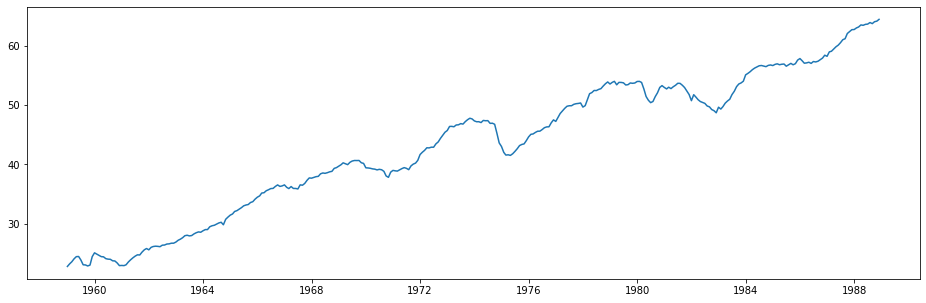

In [155]:
# series
plt.figure(figsize=(16, 5))
sns.lineplot(data=df.Value)
plt.show()

Исходный временной ряд

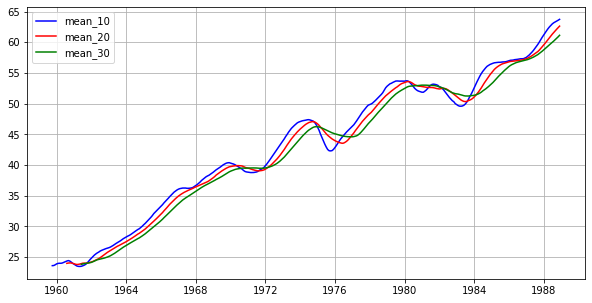

In [156]:
# rolling statistics: mean
mean_10 = df.rolling(10).mean()
mean_20 = df.rolling(20).mean()
mean_30 = df.rolling(30).mean()
plt.figure(figsize=(10, 5))
plt.plot(mean_10, color='b', label='mean_10')
plt.plot(mean_20, color='r', label='mean_20')
plt.plot(mean_30, color='g', label='mean_30')
plt.legend()
plt.grid()
plt.show()

Скользящая статистика. Среднее.

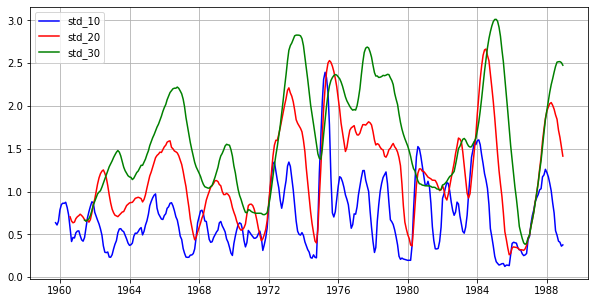

In [157]:
# rolling std
std_10 = df.rolling(10).std()
std_20 = df.rolling(20).std()
std_30 = df.rolling(30).std()
plt.figure(figsize=(10, 5))
plt.plot(std_10, color='b', label='std_10')
plt.plot(std_20, color='r', label='std_20')
plt.plot(std_30, color='g', label='std_30')
plt.legend()
plt.grid()
plt.show()

Скользящая статистика. Стандартное отклонение. 

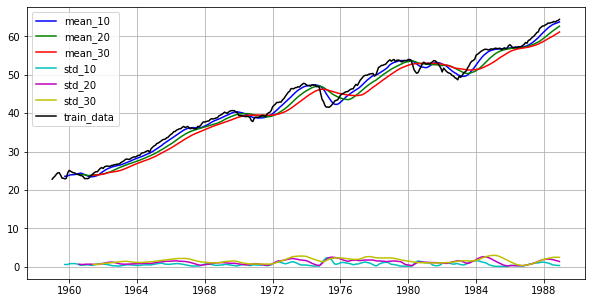

In [158]:
# numerical sirie and diff rolling stat
plt.figure(figsize=(10, 5))
plt.plot(mean_10, color='b', label='mean_10')
plt.plot(mean_20, color='g', label='mean_20')
plt.plot(mean_30, color='r', label='mean_30')
plt.plot(std_10, color='c', label='std_10')
plt.plot(std_20, color='m', label='std_20')
plt.plot(std_30, color='y', label='std_30')
plt.plot(df, 'k', label='train_data')
plt.legend()
plt.grid()
plt.show()

Данный ряд и скользящии статистики

Проверка нашего ряда на стационарность

In [159]:
DF_test(df.Value)

False

# 2

In [160]:
# Time series decompose


def decompose_time_series(x, model, freq):
    trend = x.rolling(window=freq).mean()
    if model == 'additive':
        detrend = x-trend
    else:
        detrend = x/trend

    def seasonal_mean(x, period):
        return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])
    s_a = seasonal_mean(detrend, freq)
    if model == 'additive':
        s_a -= np.mean(s_a, axis=0)
    nobs = detrend.shape[0]
    seasonal = np.tile(s_a.T, nobs // freq + 1).T[:nobs]
    if model == 'additive':
        resid = x-trend-seasonal
    else:
        resid = x/trend/seasonal
    return trend, seasonal, resid

In [161]:
def Diki_Fuller_test(a):
    test_ = sm.tsa.adfuller(a)
    print('adf: ', test_[0])
    print('p-value: ', test_[1])
    print('Critical values: ', test_[4])
    if test_[0] > test_[4]['5%']:
        print('Есть единичные корни, ряд не стационарен')
    else:
        print('Единичных корней нет, ряд стационарен')

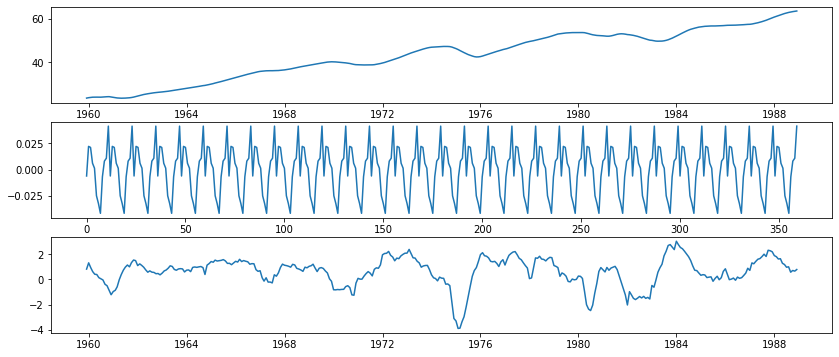

In [162]:
# Decompose Additive model
fig, axes = plt.subplots(3, 1, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(6)
result = decompose_time_series(df.Value, model='additive', freq=12)
sns.lineplot(data=result[0], ax=axes[0])
sns.lineplot(data=result[1], ax=axes[1])
sns.lineplot(data=result[2], ax=axes[2])

Разложение. Аддитивная модель
1 Тренд
2 Сезонность
3 Остаток(шум)

Проверка полученных рядов на стационарность

In [163]:
decompos = sm.tsa.seasonal_decompose(df.Value, model="additive")

In [164]:
# trend check
decompos.trend.dropna(inplace=True)
Diki_Fuller_test(decompos.trend)

In [165]:
# chech seasonality
decompos.seasonal.dropna(inplace=True)
Diki_Fuller_test(decompos.seasonal)

In [166]:
# check balance
decompos.resid.dropna(inplace=True)
Diki_Fuller_test(decompos.resid)

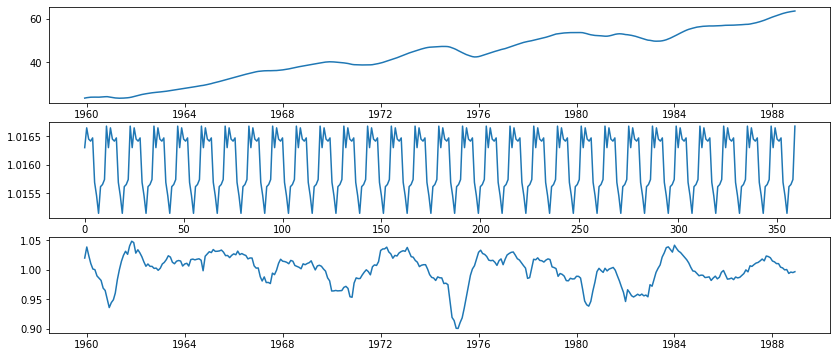

In [167]:
# Decompose multiplicative model
fig, axes = plt.subplots(3, 1, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(6)
result = decompose_time_series(df.Value,model='m',freq=12)
sns.lineplot(data=result[0], ax=axes[0])
sns.lineplot(data=result[1], ax=axes[1])
sns.lineplot(data=result[2], ax=axes[2])

Разложение. Мультиплекативная модель
1 Тренд
2 Сезонность
3 Остаток(шум)

Проверка полученных рядов на стационарность

In [168]:
decompos = sm.tsa.seasonal_decompose(df.Value, model="multiplicate")

In [169]:
# trend check
decompos.trend.dropna(inplace=True)
Diki_Fuller_test(decompos.trend)

In [170]:
# chech seasonality
decompos.seasonal.dropna(inplace=True)
Diki_Fuller_test(decompos.seasonal)

In [171]:
# check balance
decompos.resid.dropna(inplace=True)
Diki_Fuller_test(decompos.resid)

# 3

In [172]:
def k_integrability(time_series):
    k = None
    for i in range(0, 10):
        if i == 0:
            ts_copy = time_series.dropna()
        else:
            ts_copy = time_series.diff(periods=i).dropna()
        if DF_test(ts_copy)==True:
            k=i
            print("The order of integrability=",k)
            break
    return k

In [173]:
def output_acf_and_pacf(df, k, lags=30):
    df_diff = df.Value.diff(periods=k).dropna()
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_diff.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df_diff, lags=49, ax=ax2)

In [174]:
def output_model_plot(df, order, df_test):
    model = sm.tsa.ARIMA(df.Value.squeeze(), order=order).fit()
    y_r = model.predict(start=df.shape[0],
                        end=df.shape[0]+df_test.shape[0]-1, typ='levels')
    plt.figure(figsize=(15, 8))
    plt.plot(df.Value, label='Training')
    plt.plot(df_test.Value, label='Testing')
    plt.plot(y_r, label='Arima')
    plt.legend(loc='best')
    print('R2_score: ', r2_score(df_test.Value, y_r))
    print('Aic: ', model.aic)
    plt.show()

In [175]:
def find_good_model_by_aic(p, d, q, df, df_test):
    parameters = product(p, q)
    parameters_list = list(parameters)
    results = []
    best_aic = float("inf")
    for param in tqdm(parameters_list):
        fault = False
        try:
            model = sm.tsa.ARIMA(df.Value.squeeze(), order=(param[0], d, param[1])).fit()
            if fault == False:
                y_r = model.predict(start=df.shape[0],end=df.shape[0]+df_test.shape[0]-1, typ='levels')
        except ValueError:
            fault=True
            print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic,r2_score(df_test.Value,y_r)])
        fault=False
    warnings.filterwarnings('default')
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic','r2_score']
    print(result_table.sort_values(by = 'aic', ascending=True).head())
    print(result_table)
    return result_table

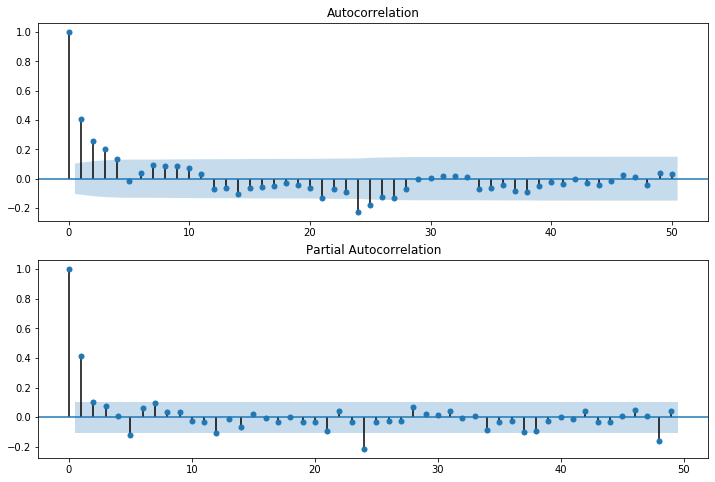

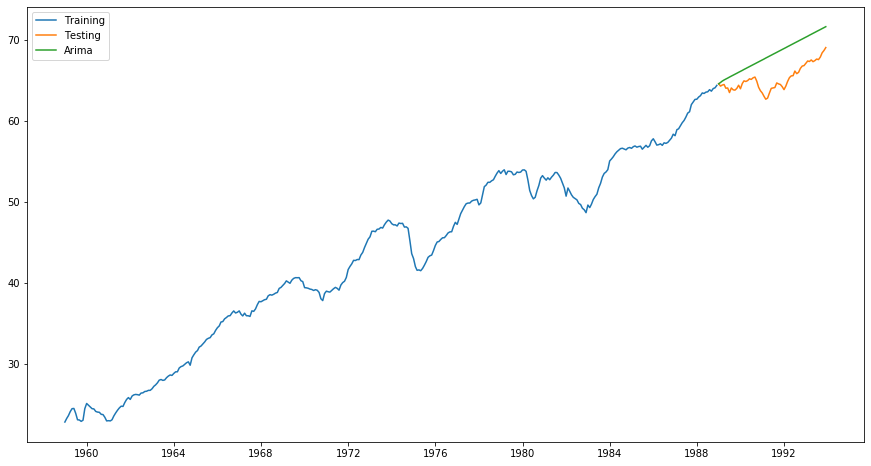

In [ ]:
k = k_integrability(df.Value)
output_acf_and_pacf(df, k, lags=50)

"""p=range(0,20)
q=range(0,20)
d=k
get_result=find_good_model_by_aic(p,d,q,df,df_test)"""

order = (3, k, 2)
output_model_plot(df, order, df_test)
order = (9, k, 4)
output_model_plot(df, order, df_test) # лучший по AIC
order = (12, k, 3)
output_model_plot(df, order, df_test) # Лучший по R2_score